In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

# Get similarity scores using each method

In [2]:
# Get similarity scores
#similarities = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m.csv')
#stein_similarities1 = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m_stein_0.6_3.csv')
#stein_similarities2 = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m_stein_0.5_2.csv')
#stein_similarities3 = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m_stein_0.5_1.csv')
#binary_similarities = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m_binary.csv')
#no_mz_similarities = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/network_method/similarities_10m_without_mz.csv')
similarities = pd.read_csv('../../data/network_method/similarities_10m.csv')
stein_similarities1 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.6_3.csv')
stein_similarities2 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.5_2.csv')
stein_similarities3 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.5_1.csv')
binary_similarities = pd.read_csv('../../data/network_method/similarities_10m_binary.csv')
no_mz_similarities = pd.read_csv('../../data/network_method/similarities_10m_without_mz.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
all_similarities = {
    'our_weights' : similarities, 
    'stein_0.6_3': stein_similarities1,
    'stein_0.5_2': stein_similarities2, 
    'stein_0.5_1': stein_similarities3,
    'binary': binary_similarities,
    'no_mz': no_mz_similarities
}

In [ ]:
# Remove rows without a tnaimoto score
for name in all_similarities.keys():
    all_similarities[name] = all_similarities[name].loc[~pd.isna(all_similarities[name]['tanimoto'])]

In [ ]:
similarities_tanimoto = {}
for name in all_similarities.keys():
    all_similarities[name]["tanimoto_interval"] = pd.cut(
        all_similarities[name]["tanimoto"],
        5,
        labels=["0.0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"],
    )
    similarities_tanimoto[name] = pd.melt(
        all_similarities[name],
        id_vars="tanimoto_interval",
        value_vars=["weighted_modified_cosine", "modified_cosine"],
    )

/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_82459/2895035681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_similarities[name]["tanimoto_interval"] = pd.cut(
/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_82459/2895035681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_similarities[name]["tanimoto_interval"] = pd.cut(
/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_82459/2895035681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

# Calculate KL divergence for each weighting method

In [ ]:
# Create df
kl_div_df = pd.DataFrame(columns=['kl_div'])

# Calculate probability density functions
tanimoto_kde = stats.gaussian_kde(np.array(list(all_similarities['our_weights'].tanimoto)))
modified_cosine_kde = stats.gaussian_kde(np.array(list(all_similarities['our_weights'].modified_cosine)))

# Calculate KL divergence for unweighted method
x_vals = np.linspace(0, 1, 200)
kl_div_df.loc['no_weights'] = stats.entropy(modified_cosine_kde(x_vals), tanimoto_kde(x_vals))

# Calculate KL divergence for each weighted method
for name in tqdm(all_similarities.keys()):
    current_kde = stats.gaussian_kde(np.array(list(all_similarities[name].weighted_modified_cosine)))
    kl_div_df.loc[name] = stats.entropy(current_kde(x_vals), tanimoto_kde(x_vals))



100%|██████████| 6/6 [01:18<00:00, 13.14s/it]


In [ ]:
kl_div_df

,kl_div
no_weights,3.056391
our_weights,1.119889
stein_0.6_3,2.541085
stein_0.5_2,2.017623
stein_0.5_1,1.671179
binary,1.184707
no_mz,1.161672


# Look at cutoffs for pairs with tanimoto > 0.8

In [ ]:
# Create dataframe
num_above = pd.DataFrame(columns=['num_above_0.5', 'num_above_0.6', 'num_above_0.7', 'num_above_0.8', 'num_above_0.9'])

# Count num scores above 0.7 for unweighted method
current_df = all_similarities['our_weights'].loc[all_similarities['our_weights']['tanimoto'] > 0.8]
num_above.loc['no_weights', 'num_above_0.5'] = len(current_df.loc[current_df['modified_cosine'] > 0.5])
num_above.loc['no_weights', 'num_above_0.6'] = len(current_df.loc[current_df['modified_cosine'] > 0.6])
num_above.loc['no_weights', 'num_above_0.7'] = len(current_df.loc[current_df['modified_cosine'] > 0.7])
num_above.loc['no_weights', 'num_above_0.8'] = len(current_df.loc[current_df['modified_cosine'] > 0.8])
num_above.loc['no_weights', 'num_above_0.9'] = len(current_df.loc[current_df['modified_cosine'] > 0.9])

# Count num scores above 0.7 for each weighted method
for name in tqdm(all_similarities.keys()):
    current_df = all_similarities[name].loc[all_similarities[name]['tanimoto'] > 0.8]
    num_above.loc[name, 'num_above_0.5'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.5])
    num_above.loc[name, 'num_above_0.6'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.6])
    num_above.loc[name, 'num_above_0.7'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.7])
    num_above.loc[name, 'num_above_0.8'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.8])
    num_above.loc[name, 'num_above_0.9'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.9])

100%|██████████| 6/6 [00:21<00:00,  3.63s/it]


In [ ]:
num_above

,num_above_0.5,num_above_0.6,num_above_0.7,num_above_0.8,num_above_0.9
no_weights,4038,3549,3023,2424,1727
our_weights,4131,2921,1785,820,220
stein_0.6_3,3727,3076,2428,1718,1023
stein_0.5_2,3932,3066,2277,1474,780
stein_0.5_1,4287,3321,2414,1502,743
binary,2317,1269,595,215,58
no_mz,3822,2626,1469,612,176


In [ ]:
from scipy.special import kl_div
sum(kl_div(modified_cosine_kde(x_vals), tanimoto_kde(x_vals)))

536.5294083630226

0it [00:00, ?it/s]

6it [01:07, 11.28s/it]


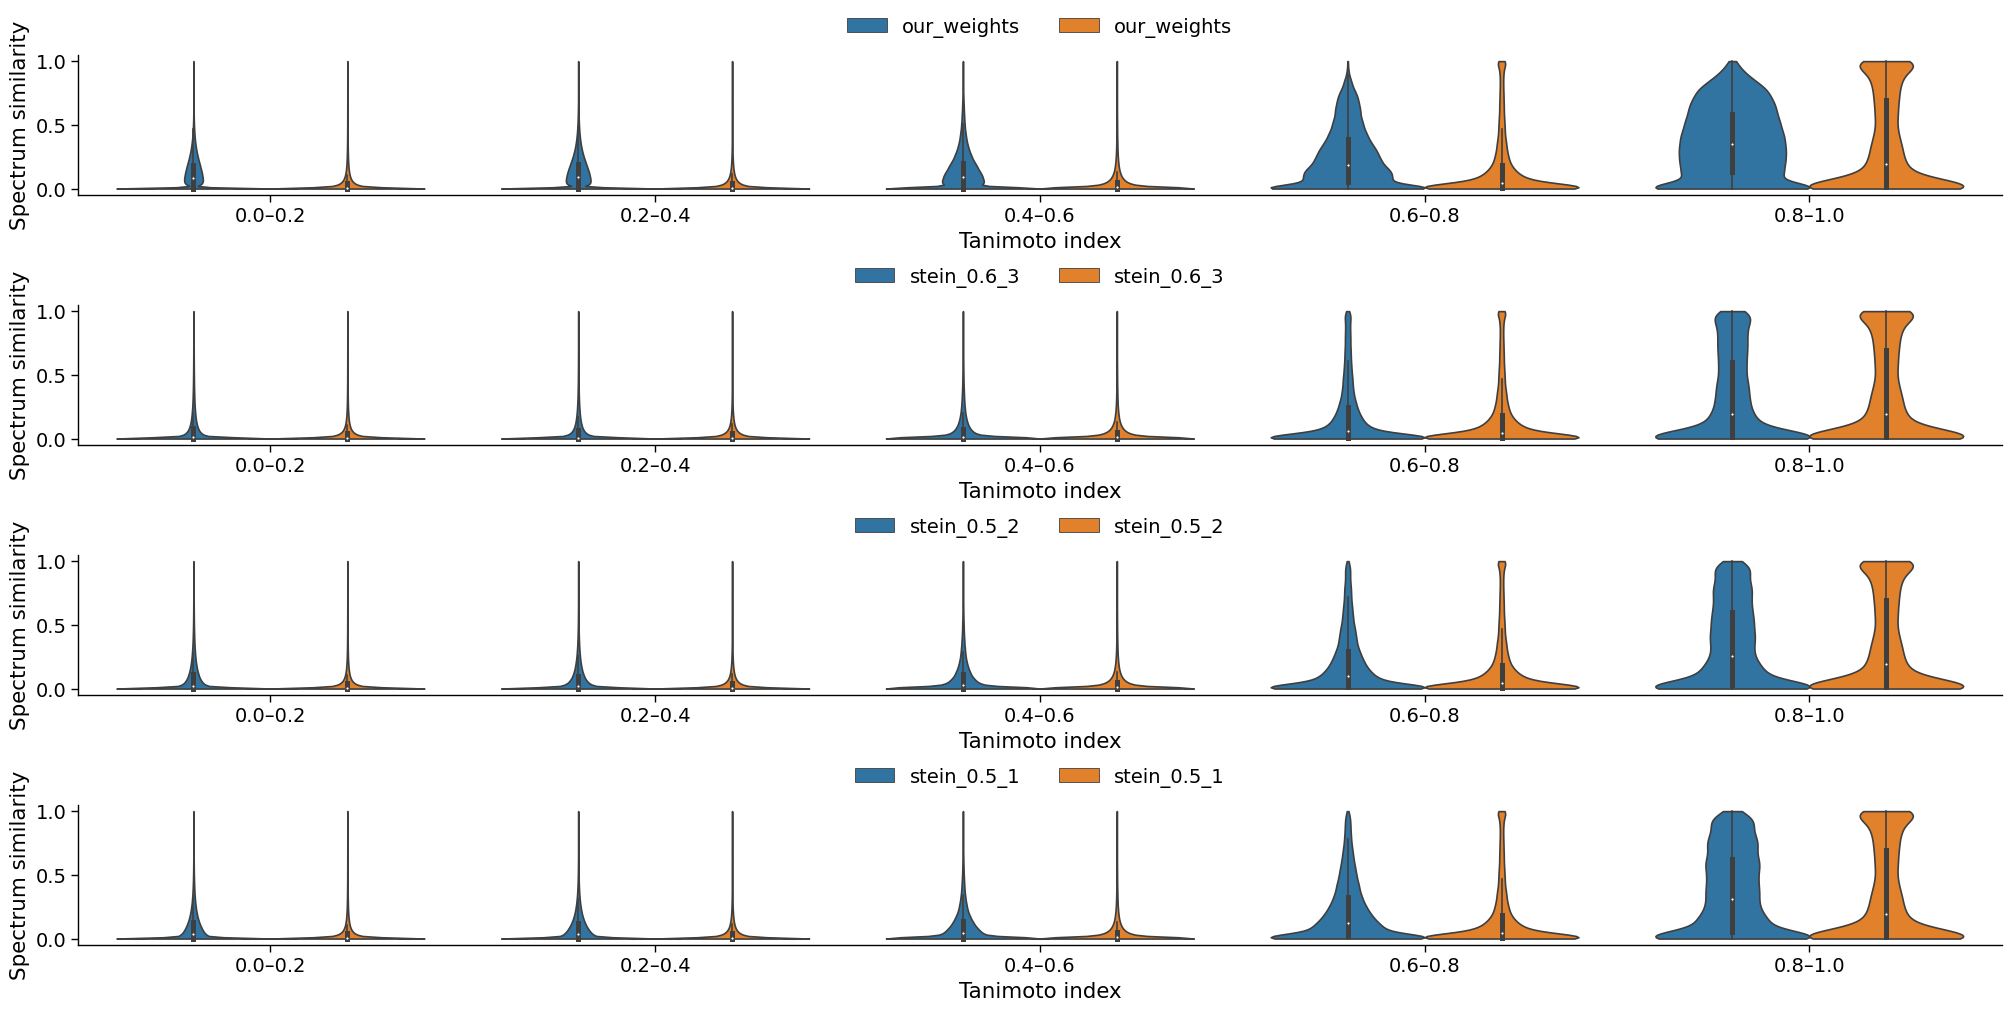

In [ ]:
with sns.plotting_context("paper", font_scale=1.6):

    label_dict = {
        "modified_cosine": "Modified cosine",
        "weighted_modified_cosine": "Modified cosine (weighted)",
        "entropy": "Spectral entropy",
        "weighted_entropy": "Spectral entropy (weighted)",
        "bhattacharya_1": "Bhattacharya distance",
        "weighted_bhattacharya_1": "Bhattacharya 1 (weighted)",
        "fidelity": "Fidelity",
        "weighted_fidelity": "Fidelity (weighted)",
    }

    fig = plt.figure(constrained_layout=True, figsize=(20, 10))

    gs = GridSpec(4, 1, figure=fig)

    

    for i, name in tqdm(enumerate(all_similarities.keys())):
        if i < 4:
            ax = fig.add_subplot(gs[i])
            sns.violinplot(
                data=similarities_tanimoto[name],
                x="tanimoto_interval",
                y="value",
                hue="variable",
                hue_order=["weighted_modified_cosine", "modified_cosine"],
                cut=0,
                scale="width",
                scale_hue=False,
                ax=ax,
            )
            ax.set_xlabel("Tanimoto index")
            ax.set_ylabel("Spectrum similarity")
            for label in ax.legend().get_texts():
                label.set_text(
                    name
                )

            sns.move_legend(
                ax,
                "lower center",
                bbox_to_anchor=(.5, 1),
                ncol=3,
                title=None,
                frameon=False,
            )

            sns.despine(ax=ax)

    # # Save figure.
    #plt.savefig("benchmark_metrics.png", dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()

# Try combined weights

In [ ]:
import numba as nb
import pyteomics.mgf

### Get Wout data

In [ ]:
# Profile spectra contain 0 intensity values.
@nb.njit
def is_centroid(intensity_array):
    return np.all(intensity_array > 0)

# Read all spectra from the MGF.
spectra = []

# Download from https://zenodo.org/record/6829249/files/ALL_GNPS_NO_PROPOGATED.mgf?download=1
filename = ("../../data/ALL_GNPS_NO_PROPOGATED.mgf")

# Get wout spectra
with pyteomics.mgf.MGF(filename) as f_in:
    for spectrum_dict in tqdm(f_in):
        spectra.append(spectrum_dict)

283175it [01:34, 279.52it/s]  

: 

: 

In [ ]:
# Create wout dataframe
wout_df = pd.DataFrame(spectra)
wout_df = pd.concat([wout_df.drop(['params'], axis=1), wout_df['params'].apply(pd.Series)], axis=1)
wout_df.head(2)